
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
Artificial Intelligence <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Spring 2024<br>
<font color=3C99D size=5>
Practical Assignment 5 - RL <br>
<font color=696880 size=4>
Amirmahdi Meighani


____

# Mountain Car

In this notebook we have a game called mountain car. the car is in a valley and at evey moment we can model its state using two floats as speed and location along x axis. You can control the car using three actions.

0: Accelerate to the left

1: Don’t accelerate

2: Accelerate to the right

the goal is to reach the peak of mountain in the minimum number of frames. because you get -1 reward for evey timestamp.

you should model the countious enviroment with a approximate descrete one and train your agent using Q learning and SARSA algorithms.


install required libraries

In [85]:
!pip install numpy
!pip install matplotlib
!pip install gymnasium

## imports

In [86]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [87]:
def visualize(env):
    '''
    use this function to see the state of the game in the current moment
    '''
    env_screen = env.render()
    plt.imshow(env_screen)
    plt.axis('off');
    title = 'speed is ' + str(env.unwrapped.state[1])

    plt.title(title)
    plt.show()

## Q Learning

in this question we have a countious enviroment but you can approximate it as a discrete enviormnet then learn and act according to that.

you can see the information of game below.

In [88]:
env = gym.make("MountainCar-v0",render_mode='rgb_array',max_episode_steps=200)
spec = gym.spec('MountainCar-v0')

Action Space: Discrete(3)
Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: -110.0



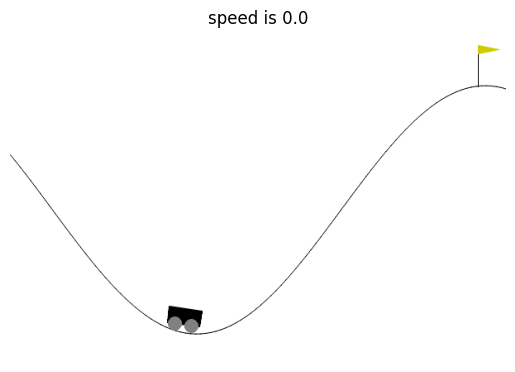

In [89]:
print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}\n")
env.reset()
visualize(env)

Observation Space:
The observation is a ndarray with shape (2,) where the elements correspond to the following:

| Num |              Observation             |  Min  |  Max |
|:---:|:------------------------------------:|:-----:|:----:|
|  0  | position of the car along the x-axis |  -1.2 |  0.6 |
|  1  | velocity of the car                  | -0.07 | 0.07 |

Action Space:
There are 3 discrete deterministic actions:

0: Accelerate to the left

1: Don’t accelerate

2: Accelerate to the right

You can play in this env yourself!!!

Try some actions and visulize the env after every 5 action. use env.step(action) function to do actions. print output of some step function. It returns five values :

new_state, reward, is_terminated ,is_truncated ,extra_info

new state after the action, reward for that action in that step, is the game terminated by reaching the goal, is the game finished by reaching 200 episode limit that is the default in this game, and some possible extra info that we don't use.


Action: 2, Next State: [-0.49675998  0.00080494], Reward: -1.0, Done: False
Action: 2, Next State: [-0.4951561   0.00160387], Reward: -1.0, Done: False
Action: 2, Next State: [-0.4927653   0.00239081], Reward: -1.0, Done: False
Action: 2, Next State: [-0.48960543  0.00315989], Reward: -1.0, Done: False
Action: 2, Next State: [-0.48570004  0.00390538], Reward: -1.0, Done: False
Action: 2, Next State: [-0.4810783   0.00462175], Reward: -1.0, Done: False
Action: 2, Next State: [-0.4757746   0.00530371], Reward: -1.0, Done: False
Action: 2, Next State: [-0.4698283   0.00594626], Reward: -1.0, Done: False
Action: 2, Next State: [-0.4632836   0.00654473], Reward: -1.0, Done: False
Action: 2, Next State: [-0.45618877  0.00709483], Reward: -1.0, Done: False
Action: 2, Next State: [-0.44859606  0.00759269], Reward: -1.0, Done: False
Action: 2, Next State: [-0.44056115  0.00803491], Reward: -1.0, Done: False
Action: 2, Next State: [-0.43214262  0.00841855], Reward: -1.0, Done: False
Action: 2, N

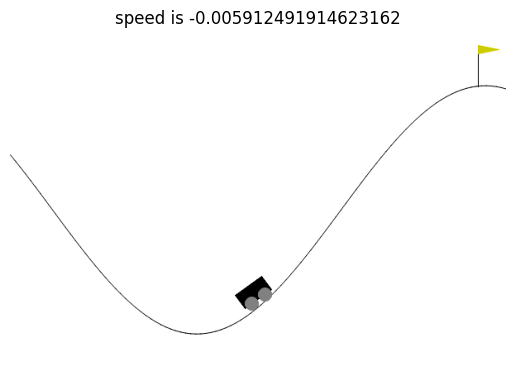

(array([-0.47004393,  0.        ], dtype=float32), {})

In [90]:
env.reset() # You can use this function to reset your environment.
######################## YOUR CODE HERE ########################
for i in range(200):
    action = 2
    next_state, reward, done, _, _ = env.step(action)
    print(f"Action: {action}, Next State: {next_state}, Reward: {reward}, Done: {done}")
    # visualize(env)
    if done:
        break
visualize(env)
######################## END YOUR CODE #########################
env.reset()

the state consists of two floats.  first one is position in x axis and second one is speed. in the next cell we will write our agent. First we need to convert continuous state to descrete so complete the relevant functions. after that we need to train our agent using Q_learning formula:


$$ Q(s,a) \leftarrow Q(s,a) + \alpha \left( r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right) $$

After training we use create policy to save your best actions. Then evaluate your policy.

In [91]:

class MountainCarQL:

    def __init__(self, env=gym.Env, discrete_size=20):

        self.discrete_size = discrete_size # number of states we use instead of each continuous argument of state
        self.env = env
        self.q_values = self.create_q_values_list()
        self.policy = {}
        # Declare any variables you need.


    def create_q_values_list(self):
        # initialize q_table and return it
        q_values = np.zeros((self.discrete_size, self.discrete_size, self.env.action_space.n))
        return q_values


    def get_discrete_state(self, state):
        x_range = env.observation_space.high[0], env.observation_space.low[0]
        v_range = env.observation_space.high[1], env.observation_space.low[1]
        x = state[0]
        v = state[1]
        x_discrete = int((x - x_range[1]) / (x_range[0] - x_range[1]) * self.discrete_size)
        v_discrete = int((v - v_range[1]) / (v_range[0] - v_range[1]) * self.discrete_size)
        return x_discrete, v_discrete


    def learn(self, num_episodes, alpha, gamma, epsilon):
        for _ in range(num_episodes):
            state = self.env.reset()[0]
            state = self.get_discrete_state(state)
            finished = False
            while not finished:
                action = self.get_action(state, epsilon)
                next_state, reward, done, trauncated, _ = self.env.step(action)
                next_state = self.get_discrete_state(next_state)
                sample_q = reward + gamma * np.max(self.q_values[next_state])
                self.update_q_values(state, action, alpha, sample_q)
                state = next_state
                finished = done or trauncated


    def get_action(self, state, epsilon):
        if random.uniform(0, 1) < epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_values[state])
        
        
    def update_q_values(self, state, action, alpha, sample_q):
        old_q = self.q_values[state][action]
        self.q_values[state][action] = (1 - alpha) * old_q + alpha * sample_q


    def create_policy(self):
        """
        Create your policy in this function after your agent learns the q_values.
        """
        for i in range(self.discrete_size):
            for j in range(self.discrete_size):
                self.policy[(i, j)] = np.argmax(self.q_values[(i, j)])
        # print(self.policy)
            

    def act(self):
        """
        Move your agent one step according to your policy.
        """
        state = self.get_discrete_state(self.env.unwrapped.state)
        action = self.policy[state]
        _, reward, done, trauncated, _ = self.env.step(action)
        return reward, done or trauncated
        



    def evaluate(self, num_episodes):
        """
        Sample num_episodes episodes from your agent that acts according to your policy.
        Then return the average rewards it gets and percentage of episodes that your car reached the goal.

        Inputs:
            - num_episodes: Number of episodes for sampling.
        Returns:
            tuple: average reward and win percentage
        """
        total_reward = 0
        win_count = 0
        for _ in range(num_episodes):
            self.env.reset()
            finished = False
            episode_reward = 0
            while not finished:
                reward, finished = self.act()
                episode_reward += reward
            if episode_reward > -200:
                win_count += 1
            total_reward += episode_reward
                
        return total_reward / num_episodes, win_count / num_episodes
        

train your agent with good parameters

In [110]:
EPISODES = 10000
LEARNING_RATE = 0.15
DISCOUNT = 0.95
EPSILON = 0.2
DISCRETE_SIZE = 35


mountain_car_ql = MountainCarQL(env,discrete_size=DISCRETE_SIZE)
mountain_car_ql.learn(EPISODES, LEARNING_RATE, DISCOUNT, EPSILON)


evaluate your agent with at least 200 episodes. your average score must be more than -170.

In [120]:
mountain_car_ql.create_policy()
avg_score, win_percentage = mountain_car_ql.evaluate(500)

print(f"Average Score: {avg_score}, Win Percentage: {win_percentage}")

Average Score: -154.92, Win Percentage: 0.998


show the path your car took for only one episode. Use visualize function every 10 frame.

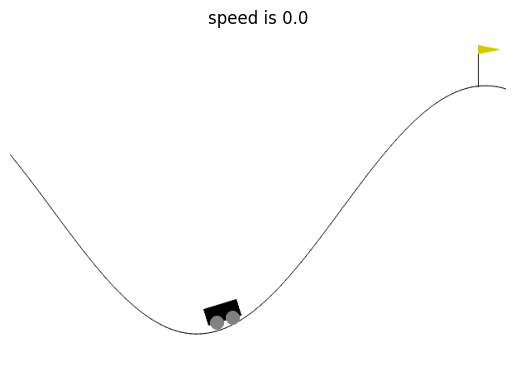

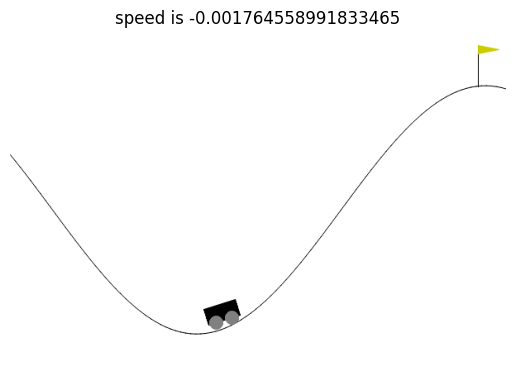

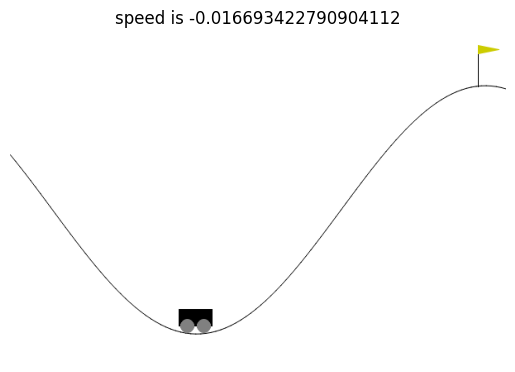

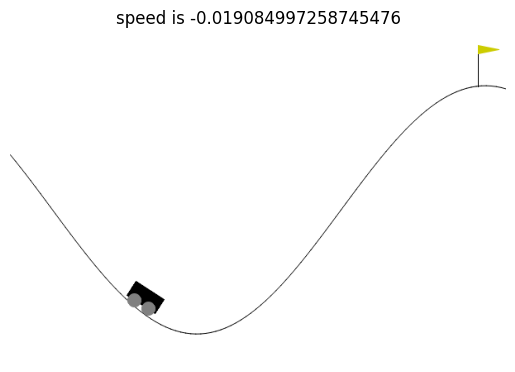

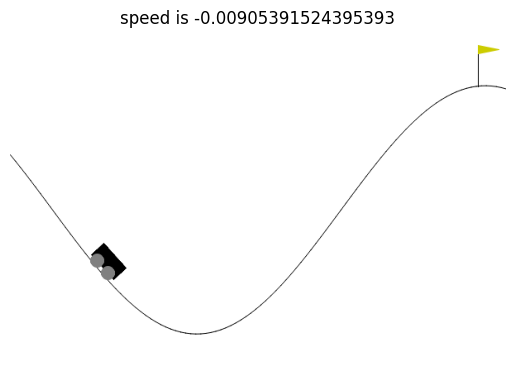

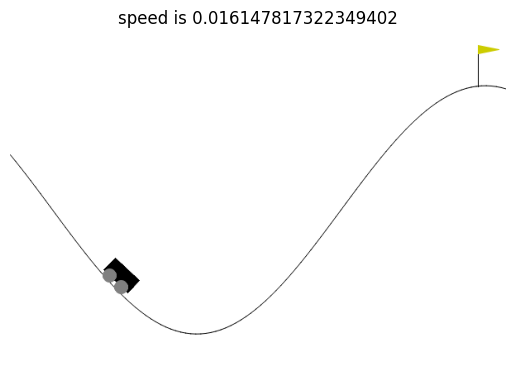

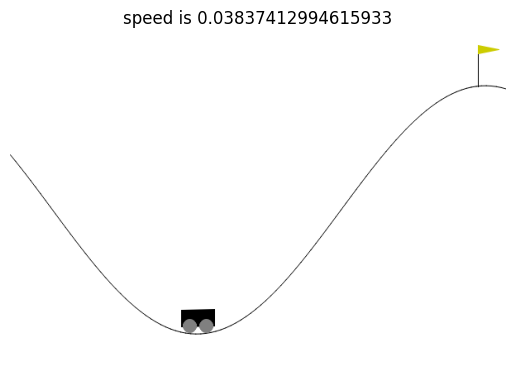

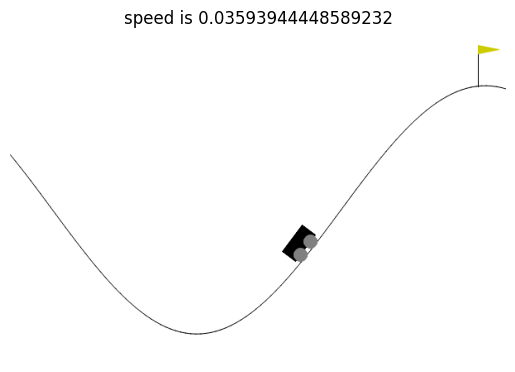

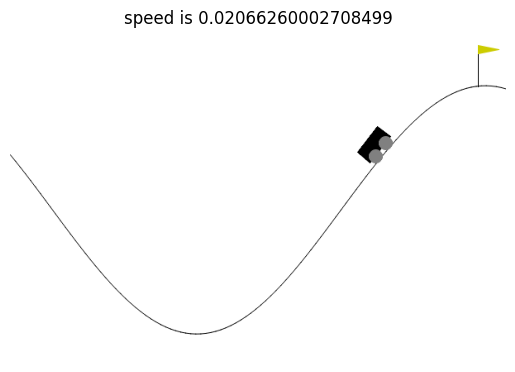

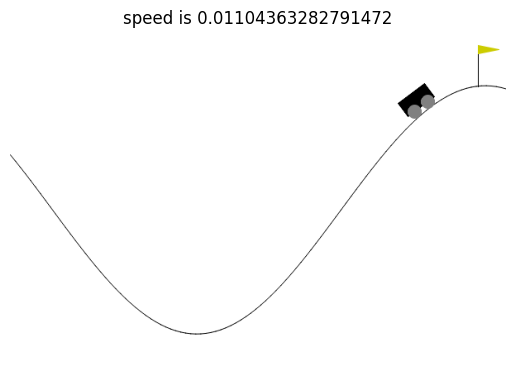

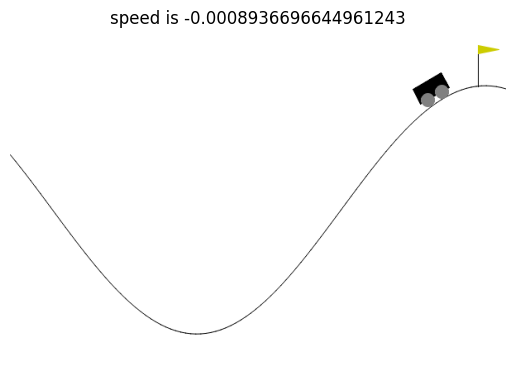

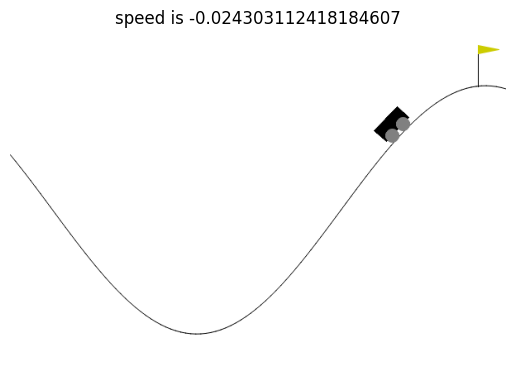

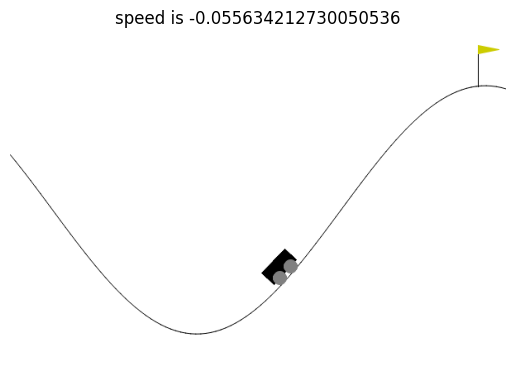

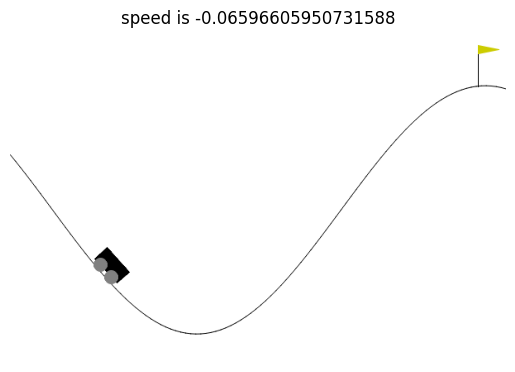

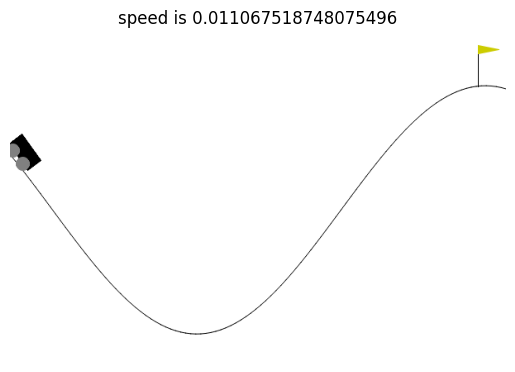

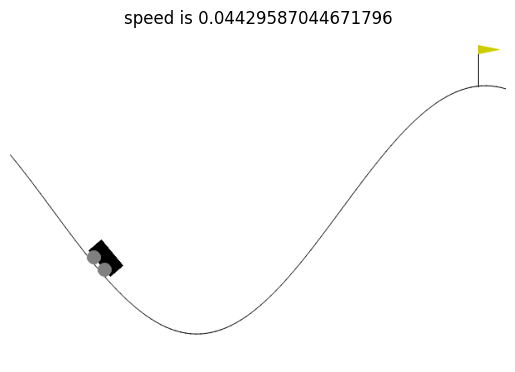

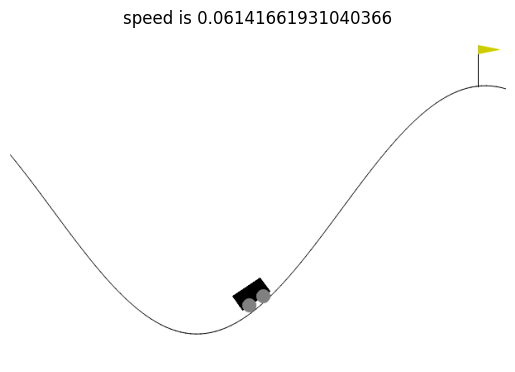

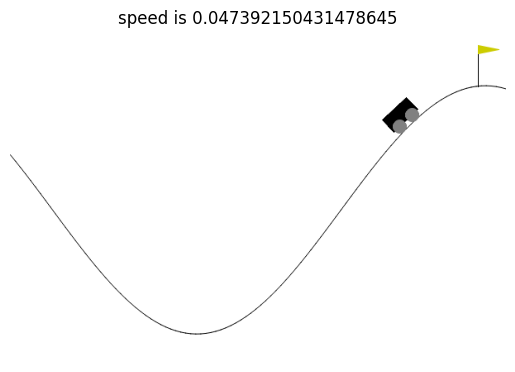

In [73]:
# show the path your car took for only one episode. Use visualize function every 10 frame.
env.reset()
visualize(env)
for i in range(200):
    reward, done = mountain_car_ql.act()
    if i % 10 == 0:
        visualize(env)
    if done:
        break

## SARSA
now we want to use sarsa algorithm here instead of Q learning. The update rule is:

$$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left( R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t) \right)$$

In [96]:
class MountainCarSarsa(MountainCarQL):

    def learn(self, num_episodes, alpha, gamma, epsilon):
        for _ in range(num_episodes):
            state = self.env.reset()[0]
            state = self.get_discrete_state(state)
            finished = False
            action = self.get_action(state, epsilon)
            while not finished:
                next_state, reward, done, trauncated, _ = self.env.step(action)
                next_state = self.get_discrete_state(next_state)
                next_action = self.get_action(next_state, epsilon)
                sample_q = reward + gamma * self.q_values[next_state][next_action]
                self.update_q_values(state, action, alpha, sample_q)
                state = next_state
                action = next_action
                finished = done or trauncated


train your agent with good parameters

In [97]:
EPISODES = 10000
LEARNING_RATE = 0.3
DISCOUNT = 0.95
EPSILON = 0.3
DISCRETE_SIZE = 35

mountain_car_sarsa = MountainCarSarsa(env,discrete_size=DISCRETE_SIZE)
mountain_car_sarsa.learn(EPISODES, LEARNING_RATE, DISCOUNT, EPSILON)


evaluate your agent with at list 200 episodes. your average score must be more than -175.

In [124]:
mountain_car_sarsa.create_policy()
avg_score, win_percentage = mountain_car_sarsa.evaluate(500)

print(f"Average Score: {avg_score}, Win Percentage: {win_percentage}")

Average Score: -150.526, Win Percentage: 0.978


show the path your car took for only one episode. Use visualize function every 10 frame.

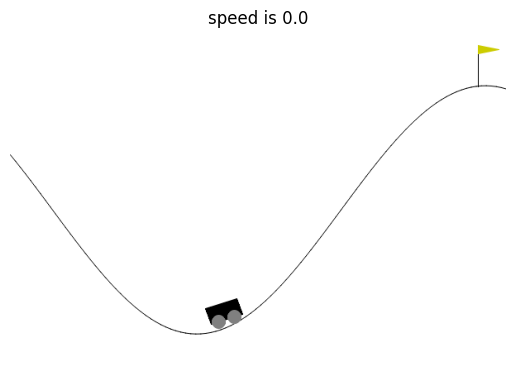

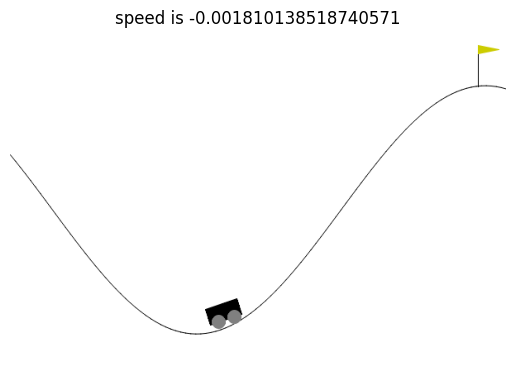

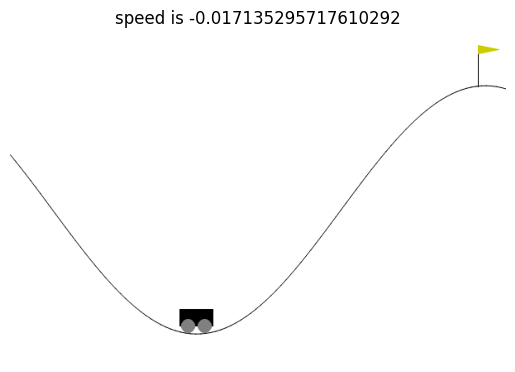

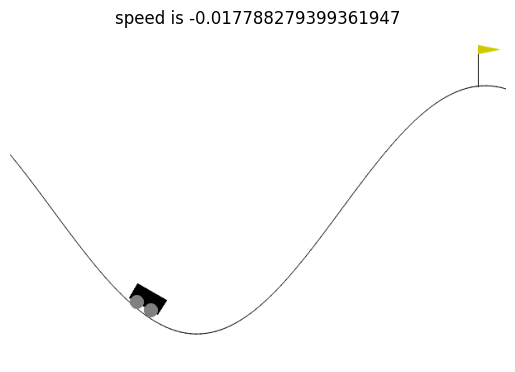

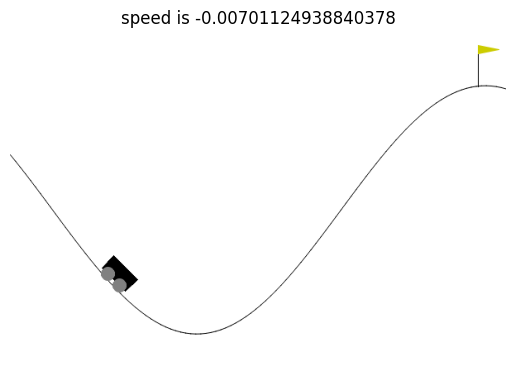

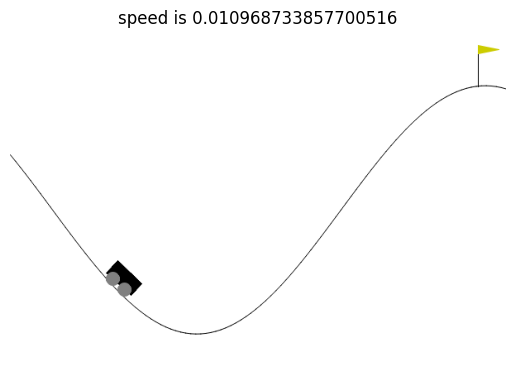

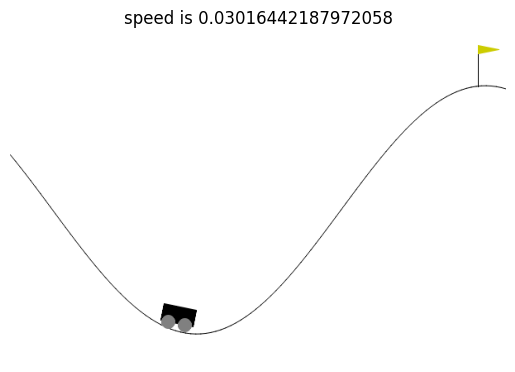

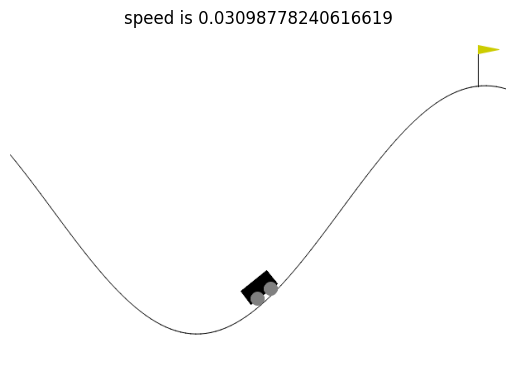

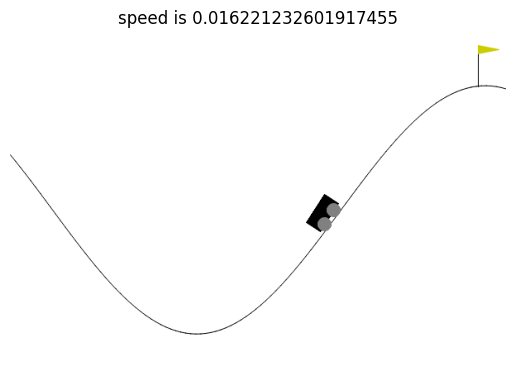

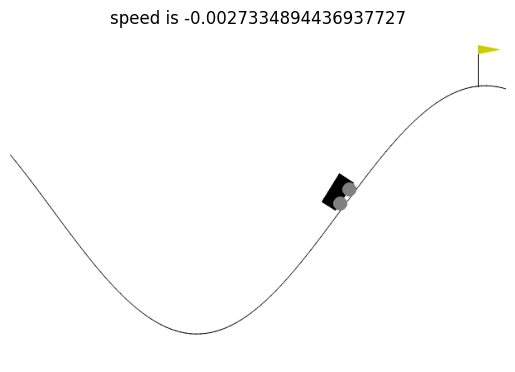

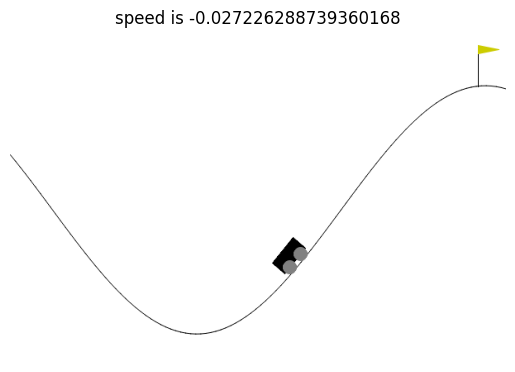

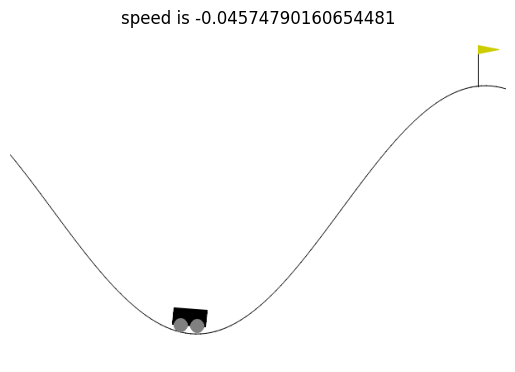

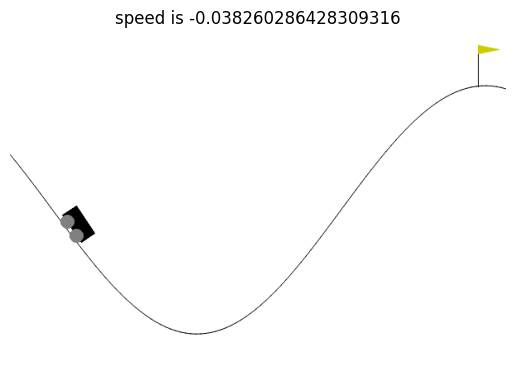

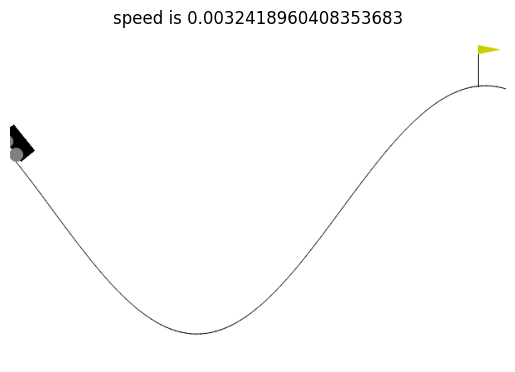

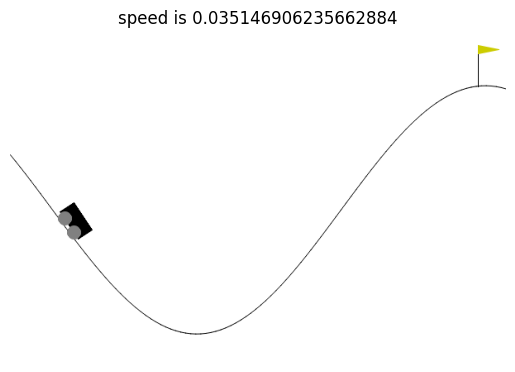

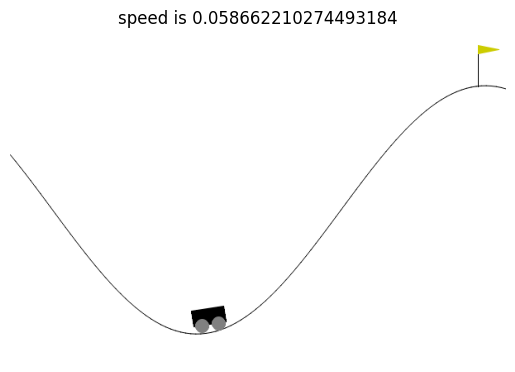

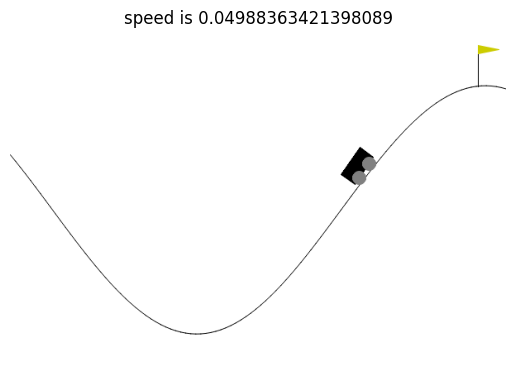

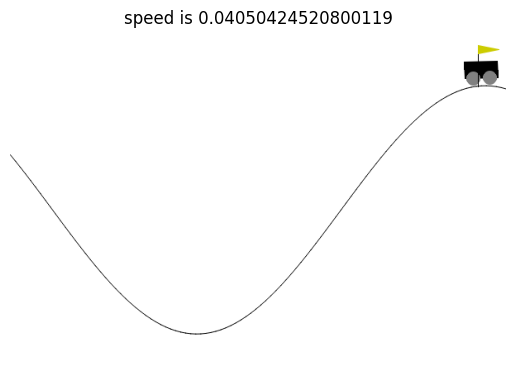

In [39]:
env.reset()
visualize(env)
for i in range(200):
    reward, done = mountain_car_ql.act()
    if i % 10 == 0:
        visualize(env)
    if done:
        break

## Final note:

We notice that the Q Value algorithm is working better than the SARSA algorithm overally having better win percentage (99.8 over 97.8). The SARSA algorithm tries to go left as much as possible and then goes to the right heel. Now I explain why.
Both algorihtms act by the epsilon-greedy policy. The SARSA algorithm tries to reach the optimal Q values assuming the epsilon-greedy algorithm and finds the best policy assuming epsilon-greedy. But the Q Value algorithm tries to find the optimal Q values and then finds the best greedy policy. So the Q Value algorithm works better when switching to the greedy policy because it assumed doing the greedy actions from the next state in the updating process.